In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import cv2
import os
import numpy as np
from keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Flatten, Dense
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, LSTM, Dense, Flatten, TimeDistributed

### Generating Frames

In [ ]:
# Define video directory and posture names
video_directory = '/content/drive/Shareddrives/Project Sleep/Generated Videos'
posture_names = ['Supine', 'Right', 'Left', 'Right', 'Right', 'Left', 'Left', 'Supine',
                 'Supine', 'Supine', 'Supine', 'Supine', 'Right Fetus', 'Left Fetus', 'Supine', 'Supine', 'Supine']

# Function to preprocess a frame
def preprocess_frame(frame, target_size=(32, 64)):
    # Resize the frame to a common size
    frame_resized = cv2.resize(frame, target_size)
    # Convert the frame to a float array and normalize pixel values
    frame_array = frame_resized.astype(np.float32) / 255.0
    return frame_array

# Function to extract frames from a video and label them
def extract_frames_and_label(video_path, label):
    cap = cv2.VideoCapture(video_path)
    frames = []

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Preprocess the frame
        preprocessed_frame = preprocess_frame(frame)

        # Append the preprocessed frame to the list
        frames.append(preprocessed_frame)

    cap.release()

    return frames, label

# Lists to store frames and labels
all_frames = []
all_labels = []

# Iterate through each video in the directory
for filename in os.listdir(video_directory):
    if filename.endswith(".mp4"): # Check if the file is a video
        posture_number = int(filename.split("_")[2][1:-4]) - 1  # Adjust index to start from 0
        label = posture_names[posture_number]
        video_path = os.path.join(video_directory, filename)
        frames, label = extract_frames_and_label(video_path, label)
        all_frames.extend(frames)
        all_labels.extend([label] * len(frames))

# Convert lists to NumPy arrays
all_frames = np.array(all_frames)
all_labels = np.array(all_labels)

print("Shape of frames array:", all_frames.shape)
print("Shape of labels array:", all_labels.shape)


Shape of frames array: (20024, 64, 32, 3)
Shape of labels array: (20024,)


In [ ]:
np.unique(all_labels)

array(['Left', 'Left Fetus', 'Right', 'Right Fetus', 'Supine'],
      dtype='<U11')

In [ ]:
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(all_labels)
label_mapping = dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))
print("Label Mapping:", label_mapping)

Label Mapping: {'Left': 0, 'Left Fetus': 1, 'Right': 2, 'Right Fetus': 3, 'Supine': 4}


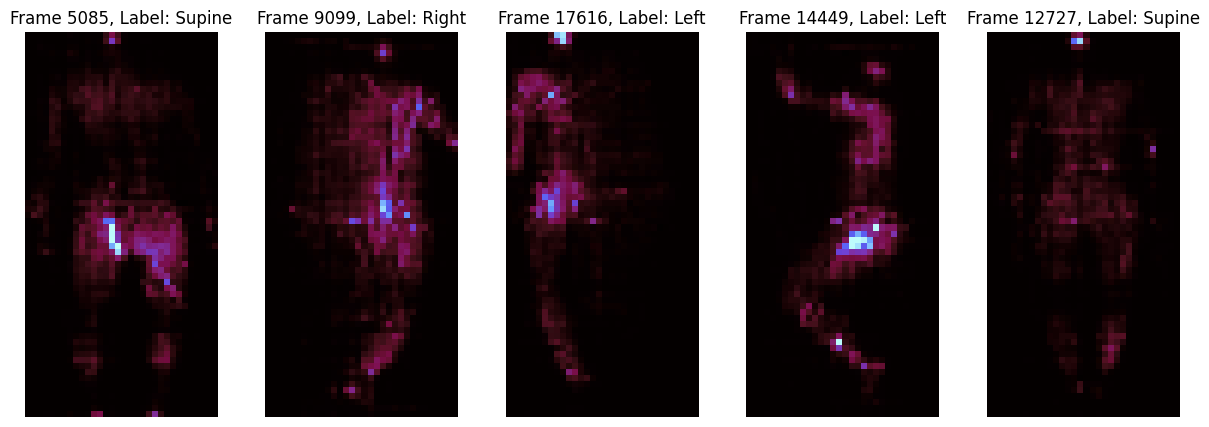

In [ ]:

# Visualize a few sample frames
num_samples = 5  # Number of sample frames to visualize
sample_indices = np.random.choice(len(all_frames), num_samples, replace=False)

plt.figure(figsize=(15, 5))
for i, idx in enumerate(sample_indices):
    plt.subplot(1, num_samples, i+1)
    plt.imshow(all_frames[idx])
    plt.title(f"Frame {idx}, Label: {all_labels[idx]}")
    plt.axis('off')

plt.show()


### Model Building 2D-CNN with LSTM

In [ ]:

#LSTM
# Encode labels
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(all_labels)  # Replace 'labels' with your actual labels
onehot_encoder = OneHotEncoder(sparse_output=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)

# Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(all_frames, onehot_encoded, test_size=0.2, random_state=42)

# Define input shape for individual frames
frame_shape = (64, 32, 3)  # Height, Width, Channels

# Define the model
model = Sequential()

# Add TimeDistributed layer around convolutional layers
model.add(TimeDistributed(Conv2D(32, kernel_size=(3, 3), activation='relu'), input_shape=(None,) + frame_shape))
model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))

model.add(TimeDistributed(Conv2D(64, kernel_size=(3, 3), activation='relu')))
model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))

# Flatten the output of the convolutional layers
model.add(TimeDistributed(Flatten()))

# Add LSTM layer to capture temporal dependencies
model.add(LSTM(128))  # Keras will infer input shape

# Add Dense layers for classification
model.add(Dense(128, activation='relu'))
model.add(Dense(len(label_encoder.classes_), activation='softmax'))  # Number of classes based on label encoding


model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# Reshape X_train and X_test
X_train = X_train.reshape(-1, 1, 64, 32, 3)
X_test = X_test.reshape(-1, 1, 64, 32, 3)

# Train the model
history = model.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_test, y_test))

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
501/501 ━━━━━━━━━━━━━━━━━━━━ 16s 15ms/step - accuracy: 0.9095 - loss: 0.2574 - val_accuracy: 0.9893 - val_loss: 0.0328
Epoch 2/10
501/501 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.9869 - loss: 0.0365 - val_accuracy: 0.9903 - val_loss: 0.0315
Epoch 3/10
501/501 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.9879 - loss: 0.0377 - val_accuracy: 0.9895 - val_loss: 0.0358
Epoch 4/10
501/501 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.9899 - loss: 0.0332 - val_accuracy: 0.9890 - val_loss: 0.0436
Epoch 5/10
501/501 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.9882 - loss: 0.0320 - val_accuracy: 0.9895 - val_loss: 0.0363
Epoch 6/10
501/501 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.9897 - loss: 0.0331 - val_accuracy: 0.9895 - val_loss: 0.0328
Epoch 7/10
501/501 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.9902 - loss: 0.0300 - val_accuracy: 0.9888 - val_loss: 0.0333
Epoch 8/10
501/501 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.9914 - loss: 0.0246 - val_accur

In [ ]:
# Sample a subset of test data for prediction
import time
sample_data = X_test  # Use the first 10 samples for testing (adjust as needed)

# Start measuring time for inference
start_time = time.time()

# Make predictions on the sample data
predictions = model.predict(sample_data)

# End measuring time
end_time = time.time()

# Calculate the total and average inference time
total_inference_time = end_time - start_time
average_inference_time_per_sample = total_inference_time / len(sample_data)

print(f"Total inference time for {len(sample_data)} samples: {total_inference_time:.4f} seconds")
print(f"Average inference time per sample: {average_inference_time_per_sample:.4f} seconds")


126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Total inference time for 4005 samples: 0.5383 seconds
Average inference time per sample: 0.0001 seconds


501/501 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step


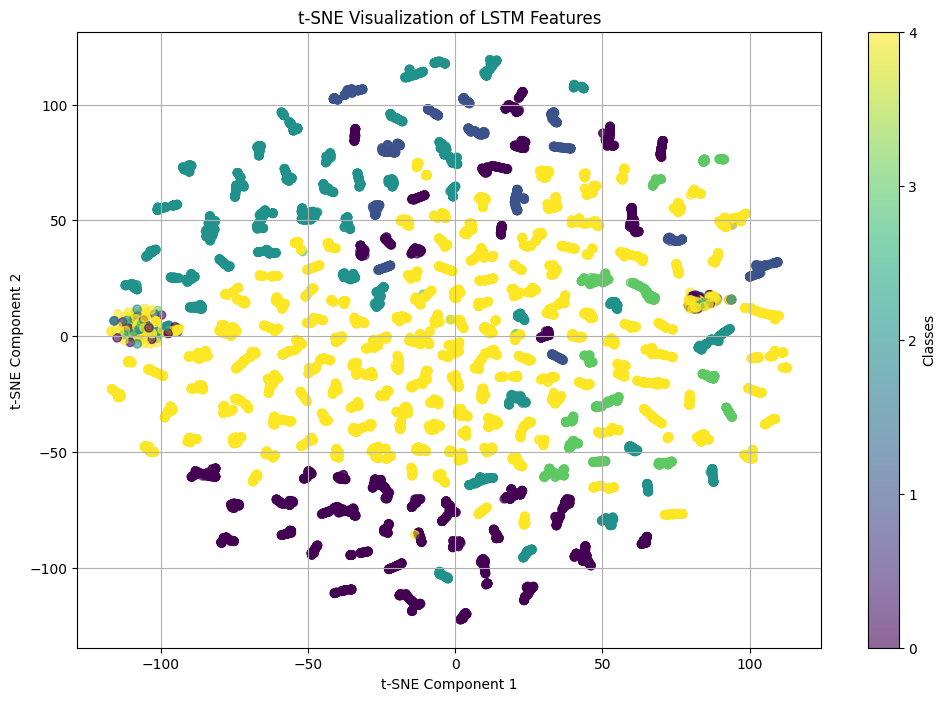

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Define a new model to extract features
feature_extractor = Sequential()
# Add TimeDistributed layer around convolutional layers
feature_extractor.add(TimeDistributed(Conv2D(32, kernel_size=(3, 3), activation='relu'), input_shape=(None,) + frame_shape))
feature_extractor.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
feature_extractor.add(TimeDistributed(Conv2D(64, kernel_size=(3, 3), activation='relu')))
feature_extractor.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
feature_extractor.add(TimeDistributed(Flatten()))
feature_extractor.add(LSTM(128))

# Extract features for the training set
X_train_features = feature_extractor.predict(X_train)

# Use t-SNE to reduce the dimensionality of the features
tsne = TSNE(n_components=2, random_state=42)
X_train_tsne = tsne.fit_transform(X_train_features)

# Plot the t-SNE results
plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_train_tsne[:, 0], X_train_tsne[:, 1], c=np.argmax(y_train, axis=1), cmap='viridis', alpha=0.6)
plt.colorbar(scatter, ticks=range(len(label_encoder.classes_)), label='Classes')
plt.title('t-SNE Visualization of LSTM Features')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.grid(True)
plt.show()


In [ ]:
from keras.models import model_from_json

# Save model architecture as JSON
model_json = model.to_json()
with open("Video_with_CNNLSTM.json", "w") as json_file:
    json_file.write(model_json)

# Save model weights
model.save_weights("Video_with_CNNLSTM_weights.h5")


### Evaluation metrics

In [ ]:
#LSTM
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score
import numpy as np

# Predict on the test set
y_pred = model.predict(X_test)

# Convert one-hot encoded predictions and true labels to label indices
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Print classification report which includes precision, recall, F1-score
print("Classification Report:")
print(classification_report(y_true_classes, y_pred_classes))

from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score, roc_auc_score
import numpy as np



# Call the confusion_matrix function to get the actual matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
print("Confusion Matrix:")
print(conf_matrix)

# Calculate Specificity for each class
specificities = []
for i in range(conf_matrix.shape[0]):
    TN = np.sum(np.delete(np.delete(conf_matrix, i, 0), i, 1))  # True Negatives
    FP = np.sum(np.delete(conf_matrix, i, 0)[:, i])  # False Positives
    specificity = TN / (TN + FP)
    specificities.append(specificity)

# Print specificities for each class
for i, spec in enumerate(specificities):
    print(f"Specificity for class {i}: {spec}")

# Precision, recall, F1-score, and AUC
precision = precision_score(y_true_classes, y_pred_classes, average='weighted')
recall = recall_score(y_true_classes, y_pred_classes, average='weighted')
f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')
auc = roc_auc_score(y_test, y_pred, multi_class='ovr')  # For multi-class classification

# Print overall metrics
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")
print(f"AUC: {auc}")


126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.99       714
           1       1.00      0.98      0.99       230
           2       1.00      0.98      0.99       695
           3       1.00      0.97      0.99       255
           4       0.98      1.00      0.99      2111

    accuracy                           0.99      4005
   macro avg       0.99      0.98      0.99      4005
weighted avg       0.99      0.99      0.99      4005

Confusion Matrix:
[[ 695    1    1    0   17]
 [   1  225    0    0    4]
 [   0    0  680    0   15]
 [   0    0    0  248    7]
 [   0    0    0    0 2111]]
Specificity for class 0: 0.9996961409905804
Specificity for class 1: 0.9997350993377483
Specificity for class 2: 0.9996978851963746
Specificity for class 3: 1.0
Specificity for class 4: 0.9772967265047519
Precision: 0.9887126800959476
Recall: 0.9885143570536828
F1-Score: 0.98849754953678

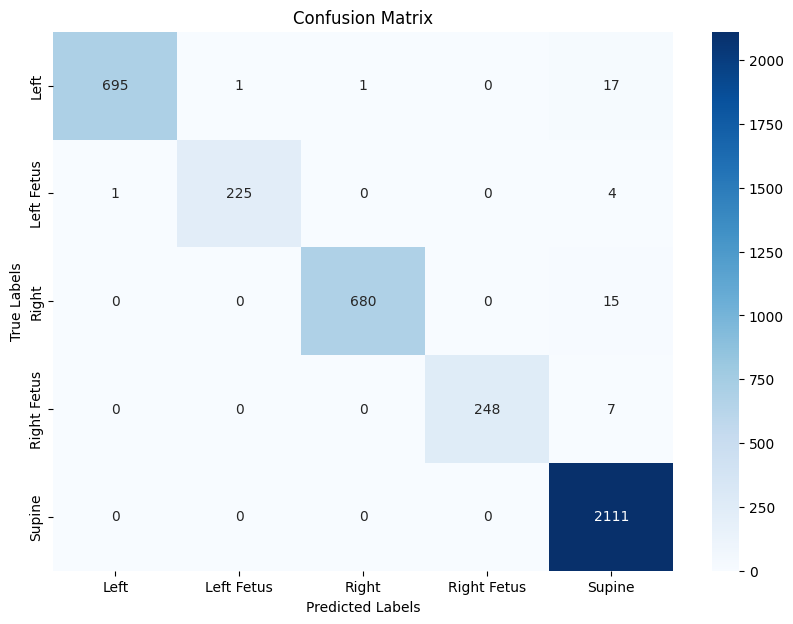

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a heatmap for the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


### Random video check

In [ ]:


def preprocess_frame(frame, target_size=(32, 64)):
    # Resize the frame to a common size
    frame_resized = cv2.resize(frame, target_size)
    # Convert the frame to a float array and normalize pixel values
    frame_array = frame_resized.astype(np.float32) / 255.0
    return frame_array# Function to extract frames from a video
def extract_frames(video_path, num_frames=64, frame_shape=(64, 32)):
    frames = []
    cap = cv2.VideoCapture(video_path)
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.resize(frame, frame_shape)
        frames.append(preprocess_frame(frame))
        if len(frames) == num_frames:
            break
    cap.release()
    return np.array(frames)

# Path to the random video
video_path = "/content/drive/Shareddrives/Project Sleep/Generated Videos/Video_S10_P17.mp4"

# Extract frames from the video
video_frames = extract_frames(video_path)

# Preprocess the frames
video_frames = video_frames.reshape(-1, 1, 64, 32, 3)

# Predict posture using the model
predictions = model.predict(video_frames)
# Decode predictions
print(predictions)
predicted_labels = label_encoder.inverse_transform(np.argmax(predictions, axis=1))

# Display predicted posture
print("Predicted Posture:", predicted_labels)


2/2 [==============================] - 0s 64ms/step
[[1.0150173e-01 7.8444727e-02 1.5984628e-01 6.2278293e-02 5.9792906e-01]
 [3.1326112e-01 3.1496041e-02 1.7508096e-01 6.8777248e-02 4.1138467e-01]
 [4.0614097e-05 1.6069169e-05 7.2151139e-05 2.7972314e-05 9.9984312e-01]
 [4.1221861e-05 1.6197240e-05 7.3128664e-05 2.8367598e-05 9.9984121e-01]
 [4.1383544e-05 1.6178879e-05 7.3190880e-05 2.8410992e-05 9.9984097e-01]
 [4.1851101e-05 1.6237409e-05 7.3815841e-05 2.8666294e-05 9.9983954e-01]
 [4.1224728e-05 1.6193240e-05 7.3144423e-05 2.8366894e-05 9.9984121e-01]
 [4.1213920e-05 1.6188671e-05 7.3130337e-05 2.8357887e-05 9.9984121e-01]
 [4.0750332e-05 1.6121858e-05 7.2507246e-05 2.8094450e-05 9.9984264e-01]
 [4.1161078e-05 1.6217778e-05 7.3201845e-05 2.8371323e-05 9.9984097e-01]
 [4.0834188e-05 1.6179394e-05 7.2765586e-05 2.8195011e-05 9.9984217e-01]
 [4.1484669e-05 1.6240132e-05 7.3529787e-05 2.8526383e-05 9.9984026e-01]
 [3.9344050e-05 1.5886793e-05 7.0388356e-05 2.7259013e-05 9.9984717e-01]

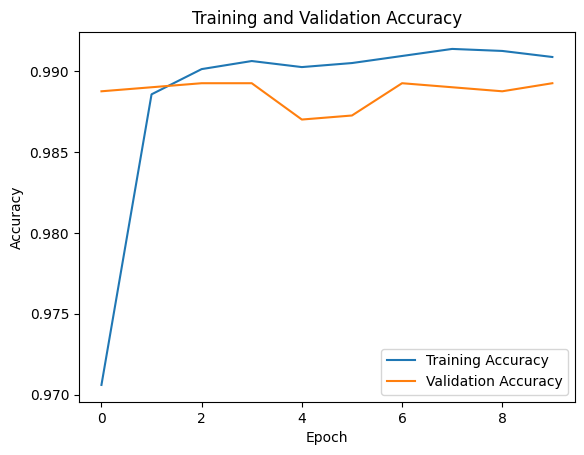

In [ ]:
#LSTM
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()


In [ ]:
#SRNN
from tensorflow.keras.layers import SimpleRNN

# Define the model
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(all_labels)  # Replace 'labels' with your actual labels
onehot_encoder = OneHotEncoder(sparse_output=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)

# Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(all_frames, onehot_encoded, test_size=0.2, random_state=42)

# Define input shape for individual frames
frame_shape = (64, 32, 3)  # Height, Width, Channels

model = Sequential()

# Add TimeDistributed layer around convolutional layers
model.add(TimeDistributed(Conv2D(32, kernel_size=(3, 3), activation='relu'), input_shape=(None,) + frame_shape))
model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))

model.add(TimeDistributed(Conv2D(64, kernel_size=(3, 3), activation='relu')))
model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))

# Flatten the output of the convolutional layers
model.add(TimeDistributed(Flatten()))

# Add SimpleRNN layer to capture temporal dependencies
model.add(SimpleRNN(128))  # Keras will infer input shape

# Add Dense layers for classification
model.add(Dense(128, activation='relu'))
model.add(Dense(len(label_encoder.classes_), activation='softmax'))  # Number of classes based on label encoding


model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# Reshape X_train and X_test
X_train = X_train.reshape(-1, 1, 64, 32, 3)
X_test = X_test.reshape(-1, 1, 64, 32, 3)

# Train the model
history = model.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_test, y_test))

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
501/501 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.9255 - loss: 0.1996 - val_accuracy: 0.9885 - val_loss: 0.0476
Epoch 2/10
501/501 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9901 - loss: 0.0320 - val_accuracy: 0.9865 - val_loss: 0.0417
Epoch 3/10
501/501 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9893 - loss: 0.0329 - val_accuracy: 0.9868 - val_loss: 0.0315
Epoch 4/10
501/501 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9908 - loss: 0.0267 - val_accuracy: 0.9895 - val_loss: 0.0358
Epoch 5/10
501/501 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9896 - loss: 0.0291 - val_accuracy: 0.9900 - val_loss: 0.0337
Epoch 6/10
501/501 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9916 - loss: 0.0247 - val_accuracy: 0.9898 - val_loss: 0.0308
Epoch 7/10
501/501 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9913 - loss: 0.0243 - val_accuracy: 0.9900 - val_loss: 0.0326
Epoch 8/10
501/501 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9913 - loss: 0.0255 - val_accuracy: 0

In [ ]:
# Sample a subset of test data for prediction
import time
sample_data = X_test  # Use the first 10 samples for testing (adjust as needed)

# Start measuring time for inference
start_time = time.time()

# Make predictions on the sample data
predictions = model.predict(sample_data)

# End measuring time
end_time = time.time()

# Calculate the total and average inference time
total_inference_time = end_time - start_time
average_inference_time_per_sample = total_inference_time / len(sample_data)

print(f"Total inference time for {len(sample_data)} samples: {total_inference_time:.4f} seconds")
print(f"Average inference time per sample: {average_inference_time_per_sample:.4f} seconds")


126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Total inference time for 4005 samples: 0.5345 seconds
Average inference time per sample: 0.0001 seconds


In [ ]:
#SRNN
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score
import numpy as np

# Predict on the test set
y_pred = model.predict(X_test)

# Convert one-hot encoded predictions and true labels to label indices
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Print classification report which includes precision, recall, F1-score
print("Classification Report:")
print(classification_report(y_true_classes, y_pred_classes))

from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score, roc_auc_score
import numpy as np



# Call the confusion_matrix function to get the actual matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
print("Confusion Matrix:")
print(conf_matrix)

# Calculate Specificity for each class
specificities = []
for i in range(conf_matrix.shape[0]):
    TN = np.sum(np.delete(np.delete(conf_matrix, i, 0), i, 1))  # True Negatives
    FP = np.sum(np.delete(conf_matrix, i, 0)[:, i])  # False Positives
    specificity = TN / (TN + FP)
    specificities.append(specificity)

# Print specificities for each class
for i, spec in enumerate(specificities):
    print(f"Specificity for class {i}: {spec}")

# Precision, recall, F1-score, and AUC
precision = precision_score(y_true_classes, y_pred_classes, average='weighted')
recall = recall_score(y_true_classes, y_pred_classes, average='weighted')
f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')
auc = roc_auc_score(y_test, y_pred, multi_class='ovr')  # For multi-class classification

# Print overall metrics
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")
print(f"AUC: {auc}")


126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       714
           1       1.00      0.98      0.99       230
           2       1.00      0.99      0.99       695
           3       0.99      0.98      0.98       255
           4       0.99      1.00      0.99      2111

    accuracy                           0.99      4005
   macro avg       0.99      0.99      0.99      4005
weighted avg       0.99      0.99      0.99      4005

Confusion Matrix:
[[ 704    0    0    2    8]
 [   2  226    1    0    1]
 [   3    0  686    0    6]
 [   1    0    1  249    4]
 [   5    0    1    1 2104]]
Specificity for class 0: 0.9966575508963841
Specificity for class 1: 1.0
Specificity for class 2: 0.9990936555891239
Specificity for class 3: 0.9992
Specificity for class 4: 0.9899683210137276
Precision: 0.9910264521115033
Recall: 0.9910112359550561
F1-Score: 0.9910047465038168
AUC: 0.99

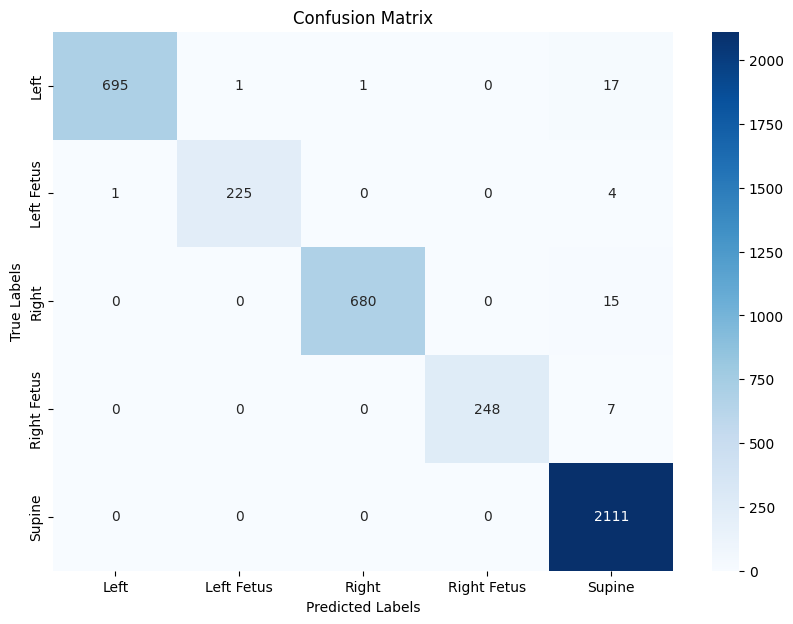

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a heatmap for the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


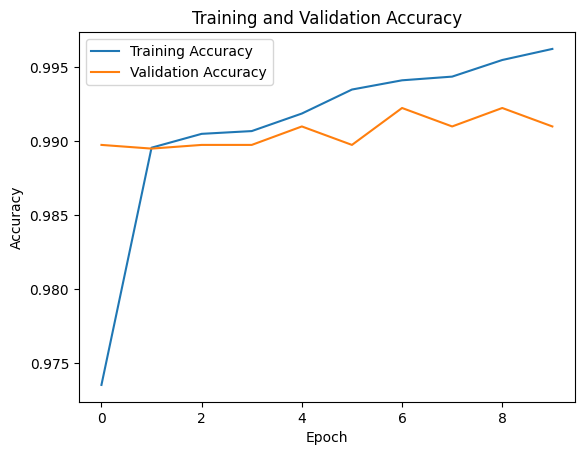

In [ ]:
#srnn
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()


In [ ]:
#BLSTM
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import TimeDistributed, Conv2D, MaxPooling2D, Flatten, Bidirectional, LSTM, Dense
import numpy as np

# Encode labels
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(all_labels)  # Replace 'labels' with your actual labels
onehot_encoder = OneHotEncoder(sparse_output=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)

# Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(all_frames, onehot_encoded, test_size=0.2, random_state=42)

# Define input shape for individual frames
frame_shape = (64, 32, 3)  # Height, Width, Channels

# Define the model
model = Sequential()

# Add TimeDistributed layer around convolutional layers
model.add(TimeDistributed(Conv2D(32, kernel_size=(3, 3), activation='relu'), input_shape=(None,) + frame_shape))
model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))

model.add(TimeDistributed(Conv2D(64, kernel_size=(3, 3), activation='relu')))
model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))

# Flatten the output of the convolutional layers
model.add(TimeDistributed(Flatten()))

# Add Bidirectional LSTM layer to capture temporal dependencies
model.add(Bidirectional(LSTM(128)))  # Bidirectional LSTM for capturing both forward and backward dependencies

# Add Dense layers for classification
model.add(Dense(128, activation='relu'))
model.add(Dense(len(label_encoder.classes_), activation='softmax'))  # Number of classes based on label encoding

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Reshape X_train and X_test to match TimeDistributed layer's requirements
X_train = X_train.reshape(-1, 1, 64, 32, 3)
X_test = X_test.reshape(-1, 1, 64, 32, 3)

# Train the model
history = model.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_test, y_test))

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
501/501 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - accuracy: 0.9221 - loss: 0.2364 - val_accuracy: 0.9888 - val_loss: 0.0418
Epoch 2/10
501/501 ━━━━━━━━━━━━━━━━━━━━ 16s 13ms/step - accuracy: 0.9890 - loss: 0.0368 - val_accuracy: 0.9895 - val_loss: 0.0367
Epoch 3/10
501/501 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.9905 - loss: 0.0312 - val_accuracy: 0.9898 - val_loss: 0.0373
Epoch 4/10
501/501 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.9912 - loss: 0.0251 - val_accuracy: 0.9870 - val_loss: 0.0338
Epoch 5/10
501/501 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.9921 - loss: 0.0252 - val_accuracy: 0.9900 - val_loss: 0.0305
Epoch 6/10
501/501 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.9921 - loss: 0.0214 - val_accuracy: 0.9898 - val_loss: 0.0289
Epoch 7/10
501/501 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.9925 - loss: 0.0214 - val_accuracy: 0.9910 - val_loss: 0.0291
Epoch 8/10
501/501 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.9933 - loss: 0.0216 - val_

In [ ]:
# Sample a subset of test data for prediction
import time
sample_data = X_test  # Use the first 10 samples for testing (adjust as needed)

# Start measuring time for inference
start_time = time.time()

# Make predictions on the sample data
predictions = model.predict(sample_data)

# End measuring time
end_time = time.time()

# Calculate the total and average inference time
total_inference_time = end_time - start_time
average_inference_time_per_sample = total_inference_time / len(sample_data)

print(f"Total inference time for {len(sample_data)} samples: {total_inference_time:.4f} seconds")
print(f"Average inference time per sample: {average_inference_time_per_sample:.4f} seconds")


126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Total inference time for 4005 samples: 0.8941 seconds
Average inference time per sample: 0.0002 seconds


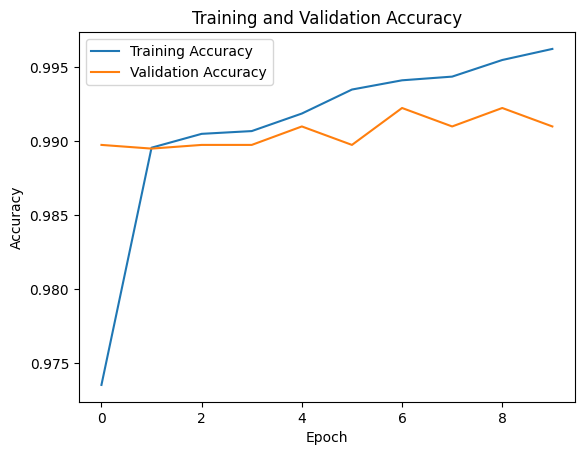

In [ ]:
#SRNN
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()


In [ ]:
from keras.models import model_from_json

# Save model architecture as JSON
model_json = model.to_json()
with open("Video_with_CNNBidirectionalLSTM.json", "w") as json_file:
    json_file.write(model_json)

# Save model weights
model.save_weights("Video_with_CNNBidirectionalLSTM.weights.h5")


In [ ]:
#BLSTM
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score
import numpy as np

# Predict on the test set
y_pred = model.predict(X_test)

# Convert one-hot encoded predictions and true labels to label indices
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Print classification report which includes precision, recall, F1-score
print("Classification Report:")
print(classification_report(y_true_classes, y_pred_classes))

from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score, roc_auc_score
import numpy as np



# Call the confusion_matrix function to get the actual matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
print("Confusion Matrix:")
print(conf_matrix)

# Calculate Specificity for each class
specificities = []
for i in range(conf_matrix.shape[0]):
    TN = np.sum(np.delete(np.delete(conf_matrix, i, 0), i, 1))  # True Negatives
    FP = np.sum(np.delete(conf_matrix, i, 0)[:, i])  # False Positives
    specificity = TN / (TN + FP)
    specificities.append(specificity)

# Print specificities for each class
for i, spec in enumerate(specificities):
    print(f"Specificity for class {i}: {spec}")

# Precision, recall, F1-score, and AUC
precision = precision_score(y_true_classes, y_pred_classes, average='weighted')
recall = recall_score(y_true_classes, y_pred_classes, average='weighted')
f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')
auc = roc_auc_score(y_test, y_pred, multi_class='ovr')  # For multi-class classification

# Print overall metrics
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")
print(f"AUC: {auc}")


126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       714
           1       1.00      0.98      0.99       230
           2       1.00      0.98      0.99       695
           3       1.00      0.97      0.99       255
           4       0.98      1.00      0.99      2111

    accuracy                           0.99      4005
   macro avg       1.00      0.98      0.99      4005
weighted avg       0.99      0.99      0.99      4005

Confusion Matrix:
[[ 697    0    1    0   16]
 [   0  225    1    0    4]
 [   0    0  682    0   13]
 [   0    0    0  248    7]
 [   0    0    0    0 2111]]
Specificity for class 0: 1.0
Specificity for class 1: 1.0
Specificity for class 2: 0.9993957703927493
Specificity for class 3: 1.0
Specificity for class 4: 0.9788806758183738
Precision: 0.9896908055759536
Recall: 0.9895131086142323
F1-Score: 0.9895004467970856
AUC: 0.9998014222767451


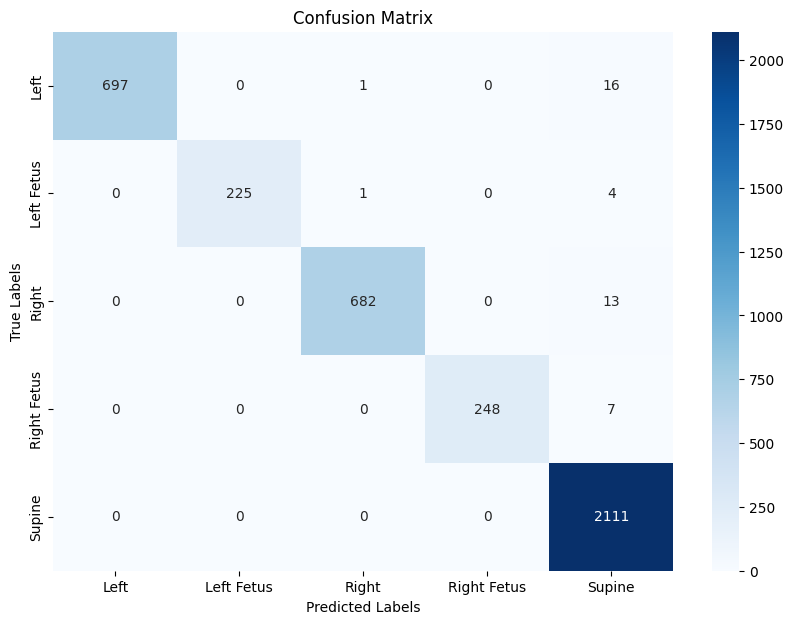

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a heatmap for the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


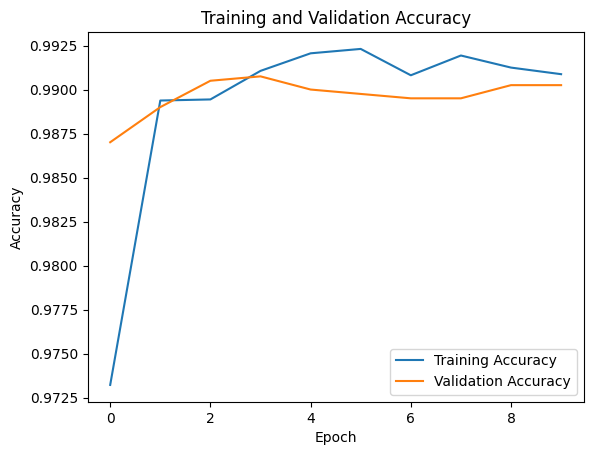

In [ ]:
#BLSTM
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()


In [ ]:
from keras.models import model_from_json

# Save model architecture as JSON
model_json = model.to_json()
with open("Video_with_CNNRNN.json", "w") as json_file:
    json_file.write(model_json)

# Save model weights
model.save_weights("Video_with_CNNRNN_weights.h5")


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

# Compute confusion matrix
y_test_single_label = np.argmax(y_test, axis=1)
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

conf_matrix = confusion_matrix(y_test_single_label, y_pred_classes)

# Print confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Compute classification report
class_report = classification_report(y_test_single_label, y_pred_classes)

# Print classification report
print("\nClassification Report:")
print(class_report)


126/126 [==============================] - 6s 43ms/step
Confusion Matrix:
[[ 698    0    0    3   13]
 [   1  227    0    0    2]
 [   1    0  686    0    8]
 [   0    0    1  249    5]
 [   0    1    0    0 2110]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       714
           1       1.00      0.99      0.99       230
           2       1.00      0.99      0.99       695
           3       0.99      0.98      0.98       255
           4       0.99      1.00      0.99      2111

    accuracy                           0.99      4005
   macro avg       0.99      0.99      0.99      4005
weighted avg       0.99      0.99      0.99      4005



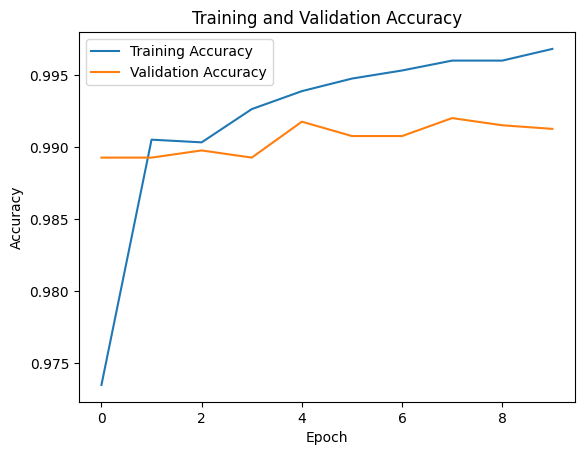

In [ ]:

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()


In [ ]:


def preprocess_frame(frame, target_size=(32, 64)):
    # Resize the frame to a common size
    frame_resized = cv2.resize(frame, target_size)
    # Convert the frame to a float array and normalize pixel values
    frame_array = frame_resized.astype(np.float32) / 255.0
    return frame_array# Function to extract frames from a video
def extract_frames(video_path, num_frames=64, frame_shape=(64, 32)):
    frames = []
    cap = cv2.VideoCapture(video_path)
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.resize(frame, frame_shape)
        frames.append(preprocess_frame(frame))
        if len(frames) == num_frames:
            break
    cap.release()
    return np.array(frames)

# Path to the random video
video_path = "/content/drive/Shareddrives/Project Sleep/Generated Videos/Video_S10_P4.mp4"

# Extract frames from the video
video_frames = extract_frames(video_path)

# Preprocess the frames
video_frames = video_frames.reshape(-1, 1, 64, 32, 3)

# Predict posture using the model
predictions = model.predict(video_frames)
# Decode predictions
predicted_labels = label_encoder.inverse_transform(np.argmax(predictions, axis=1))

# Display predicted posture
print("Predicted Posture:", predicted_labels)


2/2 [==============================] - 0s 64ms/step
Predicted Posture: ['Right' 'Left' 'Right' 'Right' 'Right' 'Right' 'Right' 'Right' 'Right'
 'Right' 'Right' 'Right' 'Right' 'Right' 'Right' 'Right' 'Right' 'Right'
 'Right' 'Right' 'Right' 'Right' 'Right' 'Right' 'Right' 'Right' 'Right'
 'Right' 'Right' 'Right' 'Right' 'Right' 'Right' 'Right' 'Right' 'Right'
 'Right' 'Right' 'Right' 'Right' 'Right' 'Right' 'Right' 'Right' 'Right'
 'Right' 'Right' 'Right' 'Right' 'Right' 'Right' 'Right' 'Right' 'Right'
 'Right' 'Right' 'Right' 'Right' 'Right' 'Right' 'Right' 'Right' 'Right'
 'Right']
